# Assignment 2.1: Feed-Forward Neural Network
Student Name 1: ...

Student Name 2: ...

Student Name 3: ...

## German Traffic Sign Benchmark

In [0]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id=1De6T4b6mtFQALtuyT05zxGkS1YHKXG01" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1De6T4b6mtFQALtuyT05zxGkS1YHKXG01" -O FullIJCNN2013.zip && rm -rf /tmp/cookies.txt
!unzip FullIJCNN2013.zip

--2020-02-24 15:06:18--  https://docs.google.com/uc?export=download&confirm=&id=1De6T4b6mtFQALtuyT05zxGkS1YHKXG01
Resolving docs.google.com (docs.google.com)... 74.125.200.100, 74.125.200.101, 74.125.200.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.200.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip       [ <=>                ]   3.03K  --.-KB/s    in 0s      

2020-02-24 15:06:18 (66.8 MB/s) - ‘FullIJCNN2013.zip’ saved [3103]

Archive:  FullIJCNN2013.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of FullIJCNN2013.zip or
        FullIJCNN2013.zip.zip, and cannot find FullIJCNN2013.zip.ZIP, period.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [3]:
!unzip 'drive/My Drive/FullIJCNN2013.zip'
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

Archive:  drive/My Drive/FullIJCNN2013.zip
replace FullIJCNN2013/00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


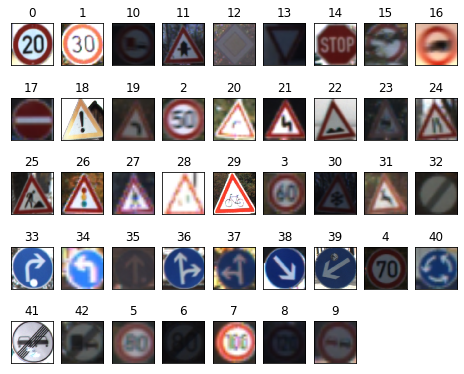

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 
np.random.seed(1996)

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

# Normalize the images to be values in range [0, 1]
tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
# Converts a class vector (integers) to binary class matrix
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

mlp = Sequential()
mlp.add(Flatten(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
mlp.add(Activation('relu'))
mlp.add(Dropout(0.1))
mlp.add(Dense(350, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
mlp.add(Activation('tanh'))
#mlp.add(LeakyReLU(alpha=0.1))
mlp.add(Dropout(0.3))
mlp.add(Dense(250, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
mlp.add(Activation('tanh'))
#mlp.add(LeakyReLU(alpha=0.1))
mlp.add(Dropout(0.3))
mlp.add(Dense(num_classes))
mlp.add(Activation('softmax'))

opt = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.99, nesterov=True)
#opt = optimizers.RMSprop(lr=1e-6, rho=0.9)
mlp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 150528)            0         
_________________________________________________________________
activation_34 (Activation)   (None, 150528)            0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 150528)            0         
_________________________________________________________________
dense_28 (Dense)             (None, 350)               52685150  
_________________________________________________________________
activation_35 (Activation)   (None, 350)               0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 350)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 250)             

In [30]:
# Set callback functions to early stop training and save the best model so far
#callbacks = [EarlyStopping(monitor='val_loss', patience=2),
#             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

data = mlp.fit(tr_signs, tr_labels, batch_size=20, epochs=150, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = mlp.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('ffNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 600 samples, validate on 252 samples
Epoch 1/150
 - 2s - loss: 13.4844 - acc: 0.0850 - val_loss: 13.1872 - val_acc: 0.2381
Epoch 2/150
 - 1s - loss: 13.1180 - acc: 0.1567 - val_loss: 12.9260 - val_acc: 0.2460
Epoch 3/150
 - 1s - loss: 12.8786 - acc: 0.2200 - val_loss: 12.7265 - val_acc: 0.2976
Epoch 4/150
 - 1s - loss: 12.6298 - acc: 0.2583 - val_loss: 12.4785 - val_acc: 0.3492
Epoch 5/150
 - 1s - loss: 12.4228 - acc: 0.3017 - val_loss: 12.3040 - val_acc: 0.3452
Epoch 6/150
 - 1s - loss: 12.1775 - acc: 0.3483 - val_loss: 12.0145 - val_acc: 0.4206
Epoch 7/150
 - 1s - loss: 11.8703 - acc: 0.3967 - val_loss: 11.8244 - val_acc: 0.4444
Epoch 8/150
 - 1s - loss: 11.6625 - acc: 0.4100 - val_loss: 11.6383 - val_acc: 0.3968
Epoch 9/150
 - 1s - loss: 11.4237 - acc: 0.4667 - val_loss: 11.4168 - val_acc: 0.4246
Epoch 10/150
 - 1s - loss: 11.2764 - acc: 0.4867 - val_loss: 11.2694 - val_acc: 0.4484
Epoch 11/150
 - 1s - loss: 11.0418 - acc: 0.4817 - val_loss: 11.0255 - val_acc: 0.5000
Epoch 

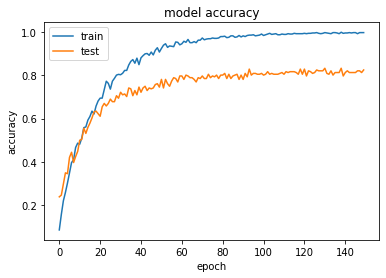

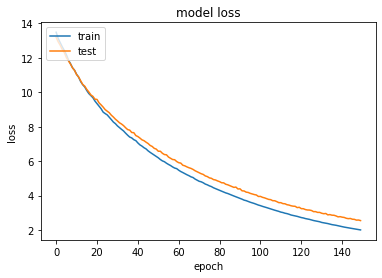

In [31]:
# summarize history for accuracy
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Test loss: 3.6197668120801616 - Accuracy: 0.7146814406083232

# CIFAR 100 Dataset

In [0]:
from keras.datasets import cifar100
(_x_train, _y_train), (_x_test, _y_test) = cifar100.load_data(label_mode='fine')


169009152/169001437 [==============================] - 13s 0us/step


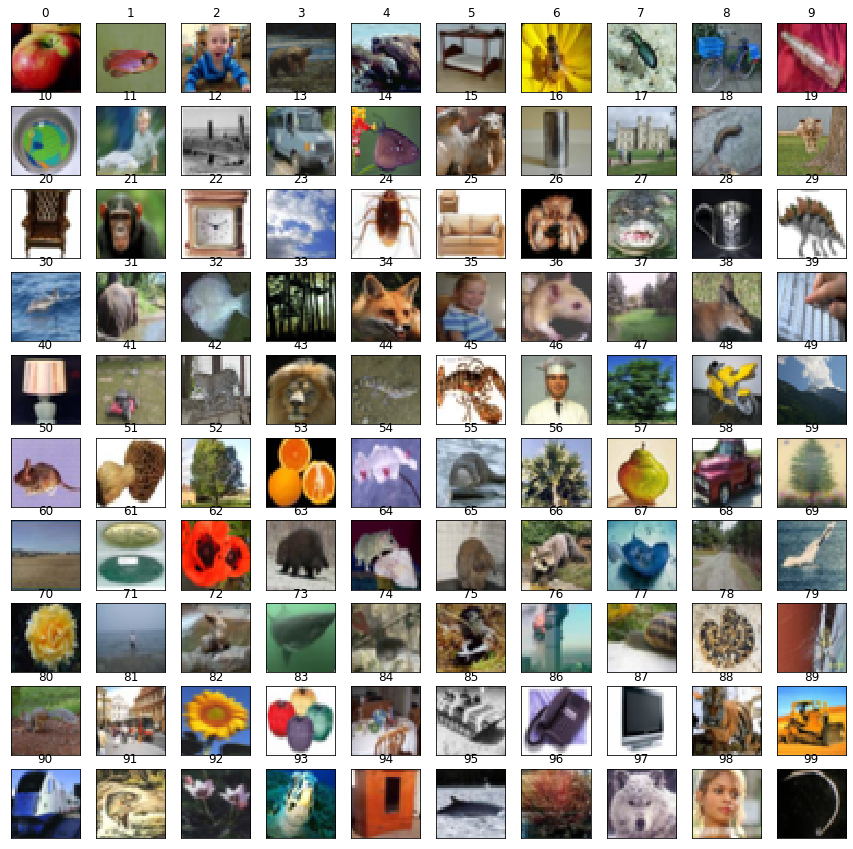

In [0]:
# Show examples from each class
class_names = np.unique(_y_train)
num_classes = len(class_names)

fig, axes = plt.subplots(10, 10,figsize=(15,15))
for i in range(num_classes):
    ax = axes.flatten()[i]
    indices = np.where(np.isin(_y_train, class_names[i]))[0]
    ax.imshow(_x_train[int(np.random.choice(indices, 1))])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(i)
plt.show()

In [0]:
# Data pre-processing
x_val = _x_train[40000:]
y_val = _y_train[40000:]
x_train = _x_train[:40000]
y_train = _y_train[:40000]
x_test = _x_test
y_test = _y_test

# Normalize the images to be values in range [0, 1]
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_val /= 255.0
x_test /= 255.0

from keras.utils import np_utils
# Converts a class vector (integers) to binary class matrix
tr_labels = np_utils.to_categorical(y_train, num_classes)
va_labels = np_utils.to_categorical(y_val, num_classes)
te_labels = np_utils.to_categorical(y_test, num_classes)

CIFAR_SIZE = (32, 32)

In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers

mlp = Sequential()
mlp.add(Flatten(input_shape=(CIFAR_SIZE[0], CIFAR_SIZE[1], 3)))
mlp.add(Activation('relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(512, activation='relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(1024, activation='tanh'))
mlp.add(Dropout(0.2))
mlp.add(Dense(512, activation='relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(num_classes))
mlp.add(Activation('softmax'))

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
mlp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
activation_5 (Activation)    (None, 3072)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)             

In [0]:
data = mlp.fit(x_train, tr_labels, batch_size=16, epochs=100, verbose=2, validation_data=(x_val, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = mlp.evaluate(x_test, te_labels, verbose=0)
end = time()
print('ffNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
 - 13s - loss: 4.3332 - acc: 0.0458 - val_loss: 4.0199 - val_acc: 0.0900
Epoch 2/100
 - 13s - loss: 3.9976 - acc: 0.0863 - val_loss: 3.7892 - val_acc: 0.1231
Epoch 3/100
 - 12s - loss: 3.8480 - acc: 0.1107 - val_loss: 3.7007 - val_acc: 0.1394
Epoch 4/100
 - 12s - loss: 3.7561 - acc: 0.1273 - val_loss: 3.6056 - val_acc: 0.1552
Epoch 5/100
 - 12s - loss: 3.6693 - acc: 0.1392 - val_loss: 3.5168 - val_acc: 0.1718
Epoch 6/100
 - 13s - loss: 3.6133 - acc: 0.1488 - val_loss: 3.4788 - val_acc: 0.1762
Epoch 7/100
 - 12s - loss: 3.5558 - acc: 0.1603 - val_loss: 3.4278 - val_acc: 0.1870
Epoch 8/100
 - 12s - loss: 3.5046 - acc: 0.1700 - val_loss: 3.4067 - val_acc: 0.1921
Epoch 9/100
 - 12s - loss: 3.4573 - acc: 0.1761 - val_loss: 3.3463 - val_acc: 0.2053
Epoch 10/100
 - 12s - loss: 3.4240 - acc: 0.1807 - val_loss: 3.3423 - val_acc: 0.2043
Epoch 11/100
 - 13s - loss: 3.3879 - acc: 0.1879 - val_loss: 3.3198 - val_acc: 0.2041
Epoch 12/100


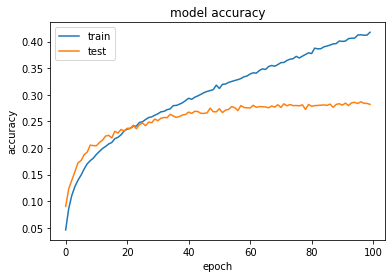

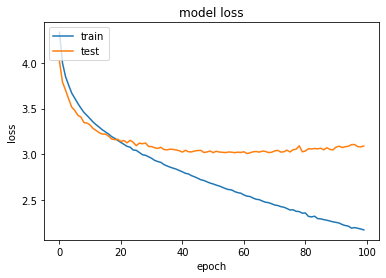

In [0]:
# summarize history for accuracy
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()